# Capstone 1
An exploration of US Census Bureau data available through the Current Population Survey (CPS), using a single month of the Basic Monthly CPS.

---

Imports and initial configuration of workspace.

In [152]:
import json
import pyspark as ps
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, when
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
%matplotlib inline

from src import datadict, quick_look

plt.rcParams['figure.figsize'] = [30, 15]


In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("Capstone 1") \
            .config("spark.sql.caseSensitive", "true")\
            .getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[4] appName=Capstone 1>

Initial exploration of a CPS dataset requires some formatting. The information needed to understand the formatting of the dataset is found in a data dictionary, with an update provided as the data format changes. 

For 2021, the dataset is located [here](https://www.census.gov/data/datasets/time-series/demo/cps/cps-basic.html). The data dictionary is [here](https://www2.census.gov/programs-surveys/cps/datasets/2021/basic/2021_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt), and is downloaded to:
`data/2021_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt`

A helper function will decompose the data dictionary into needed information for reformating the file into a usable form. 

In [3]:
headers2, locations2, sizes2, structure2 = datadict.dd_to_structure('data/2021_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt')

The file I will explore is the Basic Monthly CPS file most recently published at the time of this project. The April 2021 data is [here](https://www2.census.gov/programs-surveys/cps/datasets/2021/basic/apr21pub.dat.gz) and is downloaded and unzipped to:
`data/apr21pub.dat`

The file is read into a temporary Spark dataframe.

In [4]:
tmp_df = spark.read.text('data/apr21pub.dat')

Using the `structure2` string produced by the helper function above, a formatted dataframe is produced to allow exploration of the data. 

In [5]:
apr21_df = tmp_df.select(tmp_df.value.substr( 1, 15).alias('HRHHID'), tmp_df.value.substr(16,  2).alias('HRMONTH'), tmp_df.value.substr(18,  4).alias('HRYEAR4'), tmp_df.value.substr(22,  2).alias('HURESPLI'), tmp_df.value.substr(24,  3).alias('HUFINAL'), tmp_df.value.substr(27,  2).alias('FILLER27'), tmp_df.value.substr(29,  2).alias('HETENURE'), tmp_df.value.substr(31,  2).alias('HEHOUSUT'), tmp_df.value.substr(33,  2).alias('HETELHHD'), tmp_df.value.substr(35,  2).alias('HETELAVL'), tmp_df.value.substr(37,  2).alias('HEPHONEO'), tmp_df.value.substr(39,  2).alias('HEFAMINC'), tmp_df.value.substr(41,  2).alias('HUTYPEA'), tmp_df.value.substr(43,  2).alias('HUTYPB'), tmp_df.value.substr(45,  2).alias('HUTYPC'), tmp_df.value.substr(47, 10).alias('HWHHWGT'), tmp_df.value.substr(57,  2).alias('HRINTSTA'), tmp_df.value.substr(59,  2).alias('HRNUMHOU'), tmp_df.value.substr(61,  2).alias('HRHTYPE'), tmp_df.value.substr(63,  2).alias('HRMIS'), tmp_df.value.substr(65,  2).alias('HUINTTYP'), tmp_df.value.substr(67,  2).alias('HUPRSCNT'), tmp_df.value.substr(69,  2).alias('HRLONGLK'), tmp_df.value.substr(71,  5).alias('HRHHID2'), tmp_df.value.substr(76,  2).alias('HWHHWTLN'), tmp_df.value.substr(78,  1).alias('FILLER78'), tmp_df.value.substr(79,  2).alias('HUBUS'), tmp_df.value.substr(81,  2).alias('HUBUSL1'), tmp_df.value.substr(83,  2).alias('HUBUSL2'), tmp_df.value.substr(85,  2).alias('HUBUSL3'), tmp_df.value.substr(87,  2).alias('HUBUSL4'), tmp_df.value.substr(89,  2).alias('GEREG'), tmp_df.value.substr(91,  1).alias('GEDIV'), tmp_df.value.substr(92,  1).alias('FILLER92'), tmp_df.value.substr(93,  2).alias('GESTFIPS'), tmp_df.value.substr(95,  1).alias('FILLER95'), tmp_df.value.substr(96,  5).alias('GTCBSA'), tmp_df.value.substr(101,  3).alias('GTCO'), tmp_df.value.substr(104,  1).alias('GTCBSAST'), tmp_df.value.substr(105,  1).alias('GTMETSTA'), tmp_df.value.substr(106,  1).alias('GTINDVPC'), tmp_df.value.substr(107,  1).alias('GTCBSASZ'), tmp_df.value.substr(108,  3).alias('GTCSA'), tmp_df.value.substr(111,  3).alias('FILLER111'), tmp_df.value.substr(114,  2).alias('FILLER114'), tmp_df.value.substr(118,  2).alias('PERRP'), tmp_df.value.substr(120,  2).alias('FILLER120'), tmp_df.value.substr(122,  2).alias('PRTAGE'), tmp_df.value.substr(124,  1).alias('PRTFAGE'), tmp_df.value.substr(125,  2).alias('PEMARITL'), tmp_df.value.substr(127,  2).alias('PESPOUSE'), tmp_df.value.substr(129,  2).alias('PESEX'), tmp_df.value.substr(131,  2).alias('PEAFEVER'), tmp_df.value.substr(133,  2).alias('FILLER133'), tmp_df.value.substr(135,  2).alias('PEAFNOW'), tmp_df.value.substr(137,  2).alias('PEEDUCA'), tmp_df.value.substr(139,  2).alias('PTDTRACE'), tmp_df.value.substr(141,  2).alias('PRDTHSP'), tmp_df.value.substr(143,  2).alias('PUCHINHH'), tmp_df.value.substr(145,  2).alias('FILLER145'), tmp_df.value.substr(147,  2).alias('PULINENO'), tmp_df.value.substr(149,  2).alias('FILLER149'), tmp_df.value.substr(151,  2).alias('PRFAMNUM'), tmp_df.value.substr(153,  2).alias('PRFAMREL'), tmp_df.value.substr(155,  2).alias('PRFAMTYP'), tmp_df.value.substr(157,  2).alias('PEHSPNON'), tmp_df.value.substr(159,  2).alias('PRMARSTA'), tmp_df.value.substr(161,  2).alias('PRPERTYP'), tmp_df.value.substr(163,  3).alias('PENATVTY'), tmp_df.value.substr(166,  3).alias('PEMNTVTY'), tmp_df.value.substr(169,  3).alias('PEFNTVTY'), tmp_df.value.substr(172,  2).alias('PRCITSHP'), tmp_df.value.substr(174,  2).alias('PRCITFLG'), tmp_df.value.substr(176,  2).alias('PRINUSYR'), tmp_df.value.substr(178,  2).alias('PUSLFPRX'), tmp_df.value.substr(180,  2).alias('PEMLR'), tmp_df.value.substr(182,  2).alias('PUWK'), tmp_df.value.substr(184,  2).alias('PUBUS1'), tmp_df.value.substr(186,  2).alias('PUBUS2OT'), tmp_df.value.substr(188,  2).alias('PUBUSCK1'), tmp_df.value.substr(190,  2).alias('PUBUSCK2'), tmp_df.value.substr(192,  2).alias('PUBUSCK3'), tmp_df.value.substr(194,  2).alias('PUBUSCK4'), tmp_df.value.substr(196,  2).alias('PURETOT'), tmp_df.value.substr(198,  2).alias('PUDIS'), tmp_df.value.substr(200,  2).alias('PERET1'), tmp_df.value.substr(202,  2).alias('PUDIS1'), tmp_df.value.substr(204,  2).alias('PUDIS2'), tmp_df.value.substr(206,  2).alias('PUABSOT'), tmp_df.value.substr(208,  2).alias('PULAY'), tmp_df.value.substr(210,  2).alias('PEABSRSN'), tmp_df.value.substr(212,  2).alias('PEABSPDO'), tmp_df.value.substr(214,  2).alias('PEMJOT'), tmp_df.value.substr(216,  2).alias('PEMJNUM'), tmp_df.value.substr(218,  2).alias('PEHRUSL1'), tmp_df.value.substr(220,  2).alias('PEHRUSL2'), tmp_df.value.substr(222,  2).alias('PEHRFTPT'), tmp_df.value.substr(224,  3).alias('PEHRUSLT'), tmp_df.value.substr(227,  2).alias('PEHRWANT'), tmp_df.value.substr(229,  2).alias('PEHRRSN1'), tmp_df.value.substr(231,  2).alias('PEHRRSN2'), tmp_df.value.substr(233,  2).alias('PEHRRSN3'), tmp_df.value.substr(235,  2).alias('PUHROFF1'), tmp_df.value.substr(237,  2).alias('PUHROFF2'), tmp_df.value.substr(239,  2).alias('PUHROT1'), tmp_df.value.substr(241,  2).alias('PUHROT2'), tmp_df.value.substr(243,  2).alias('PEHRACT1'), tmp_df.value.substr(245,  2).alias('PEHRACT2'), tmp_df.value.substr(247,  3).alias('PEHRACTT'), tmp_df.value.substr(250,  2).alias('PEHRAVL'), tmp_df.value.substr(252,  5).alias('FILLER252'), tmp_df.value.substr(257,  2).alias('PUHRCK1'), tmp_df.value.substr(259,  2).alias('PUHRCK2'), tmp_df.value.substr(261,  2).alias('PUHRCK3'), tmp_df.value.substr(263,  2).alias('PUHRCK4'), tmp_df.value.substr(265,  2).alias('PUHRCK5'), tmp_df.value.substr(267,  2).alias('PUHRCK6'), tmp_df.value.substr(269,  2).alias('PUHRCK7'), tmp_df.value.substr(271,  2).alias('PUHRCK12'), tmp_df.value.substr(273,  2).alias('PULAYDT'), tmp_df.value.substr(275,  2).alias('PULAY6M'), tmp_df.value.substr(277,  2).alias('PELAYAVL'), tmp_df.value.substr(279,  2).alias('PULAYAVR'), tmp_df.value.substr(281,  2).alias('PELAYLK'), tmp_df.value.substr(283,  3).alias('PELAYDUR'), tmp_df.value.substr(286,  2).alias('PELAYFTO'), tmp_df.value.substr(288,  2).alias('PULAYCK1'), tmp_df.value.substr(290,  2).alias('PULAYCK2'), tmp_df.value.substr(292,  2).alias('PULAYCK3'), tmp_df.value.substr(294,  2).alias('PULK'), tmp_df.value.substr(296,  2).alias('PELKM1'), tmp_df.value.substr(298,  2).alias('PULKM2'), tmp_df.value.substr(300,  2).alias('PULKM3'), tmp_df.value.substr(302,  2).alias('PULKM4'), tmp_df.value.substr(304,  2).alias('PULKM5'), tmp_df.value.substr(306,  2).alias('PULKM6'), tmp_df.value.substr(308,  2).alias('PULKDK1'), tmp_df.value.substr(310,  2).alias('PULKDK2'), tmp_df.value.substr(312,  2).alias('PULKDK3'), tmp_df.value.substr(314,  2).alias('PULKDK4'), tmp_df.value.substr(316,  2).alias('PULKDK5'), tmp_df.value.substr(318,  2).alias('PULKDK6'), tmp_df.value.substr(320,  2).alias('PULKPS1'), tmp_df.value.substr(322,  2).alias('PULKPS2'), tmp_df.value.substr(324,  2).alias('PULKPS3'), tmp_df.value.substr(326,  2).alias('PULKPS4'), tmp_df.value.substr(328,  2).alias('PULKPS5'), tmp_df.value.substr(330,  2).alias('PULKPS6'), tmp_df.value.substr(332,  2).alias('PELKAVL'), tmp_df.value.substr(334,  2).alias('PULKAVR'), tmp_df.value.substr(336,  2).alias('PELKLL1O'), tmp_df.value.substr(338,  2).alias('PELKLL2O'), tmp_df.value.substr(340,  2).alias('PELKLWO'), tmp_df.value.substr(342,  3).alias('PELKDUR'), tmp_df.value.substr(345,  2).alias('PELKFTO'), tmp_df.value.substr(347,  2).alias('PEDWWNTO'), tmp_df.value.substr(349,  2).alias('PEDWRSN'), tmp_df.value.substr(351,  2).alias('PEDWLKO'), tmp_df.value.substr(353,  2).alias('PEDWWK'), tmp_df.value.substr(355,  2).alias('PEDW4WK'), tmp_df.value.substr(357,  2).alias('PEDWLKWK'), tmp_df.value.substr(359,  2).alias('PEDWAVL'), tmp_df.value.substr(361,  2).alias('PEDWAVR'), tmp_df.value.substr(363,  2).alias('PUDWCK1'), tmp_df.value.substr(365,  2).alias('PUDWCK2'), tmp_df.value.substr(367,  2).alias('PUDWCK3'), tmp_df.value.substr(369,  2).alias('PUDWCK4'), tmp_df.value.substr(371,  2).alias('PUDWCK5'), tmp_df.value.substr(373,  2).alias('PEJHWKO'), tmp_df.value.substr(375,  2).alias('PUJHDP1O'), tmp_df.value.substr(377,  2).alias('PEJHRSN'), tmp_df.value.substr(379,  2).alias('PEJHWANT'), tmp_df.value.substr(381,  2).alias('PUJHCK1'), tmp_df.value.substr(383,  2).alias('PUJHCK2'), tmp_df.value.substr(385,  2).alias('PRABSREA'), tmp_df.value.substr(387,  2).alias('PRCIVLF'), tmp_df.value.substr(389,  2).alias('PRDISC'), tmp_df.value.substr(391,  2).alias('PREMPHRS'), tmp_df.value.substr(393,  2).alias('PREMPNOT'), tmp_df.value.substr(395,  2).alias('PREXPLF'), tmp_df.value.substr(397,  2).alias('PRFTLF'), tmp_df.value.substr(399,  2).alias('PRHRUSL'), tmp_df.value.substr(401,  2).alias('PRJOBSEA'), tmp_df.value.substr(403,  2).alias('PRPTHRS'), tmp_df.value.substr(405,  2).alias('PRPTREA'), tmp_df.value.substr(407,  3).alias('PRUNEDUR'), tmp_df.value.substr(410,  2).alias('FILLER410'), tmp_df.value.substr(412,  2).alias('PRUNTYPE'), tmp_df.value.substr(414,  2).alias('PRWKSCH'), tmp_df.value.substr(416,  2).alias('PRWKSTAT'), tmp_df.value.substr(418,  2).alias('PRWNTJOB'), tmp_df.value.substr(420,  2).alias('PUJHCK3'), tmp_df.value.substr(422,  2).alias('PUJHCK4'), tmp_df.value.substr(424,  2).alias('PUJHCK5'), tmp_df.value.substr(426,  2).alias('PUIODP1'), tmp_df.value.substr(428,  2).alias('PUIODP2'), tmp_df.value.substr(430,  2).alias('PUIODP3'), tmp_df.value.substr(432,  2).alias('PEIO1COW'), tmp_df.value.substr(434,  2).alias('PUIO1MFG'), tmp_df.value.substr(436,  6).alias('PADDING436'), tmp_df.value.substr(442,  2).alias('PEIO2COW'), tmp_df.value.substr(444,  2).alias('PUIO2MFG'), tmp_df.value.substr(446,  6).alias('PADDING446'), tmp_df.value.substr(452,  2).alias('PUIOCK1'), tmp_df.value.substr(454,  2).alias('PUIOCK2'), tmp_df.value.substr(456,  2).alias('PUIOCK3'), tmp_df.value.substr(458,  2).alias('PRIOELG'), tmp_df.value.substr(460,  2).alias('PRAGNA'), tmp_df.value.substr(462,  2).alias('PRCOW1'), tmp_df.value.substr(464,  2).alias('PRCOW2'), tmp_df.value.substr(466,  2).alias('PRCOWPG'), tmp_df.value.substr(468,  2).alias('PRDTCOW1'), tmp_df.value.substr(470,  2).alias('PRDTCOW2'), tmp_df.value.substr(472,  2).alias('PRDTIND1'), tmp_df.value.substr(474,  2).alias('PRDTIND2'), tmp_df.value.substr(476,  2).alias('PRDTOCC1'), tmp_df.value.substr(478,  2).alias('PRDTOCC2'), tmp_df.value.substr(480,  2).alias('PREMP'), tmp_df.value.substr(482,  2).alias('PRMJIND1'), tmp_df.value.substr(484,  2).alias('PRMJIND2'), tmp_df.value.substr(486,  2).alias('PRMJOCC1'), tmp_df.value.substr(488,  2).alias('PRMJOCC2'), tmp_df.value.substr(490,  2).alias('PRMJOCGR'), tmp_df.value.substr(492,  2).alias('PRNAGPWS'), tmp_df.value.substr(494,  2).alias('PRNAGWS'), tmp_df.value.substr(496,  2).alias('PRSJMS'), tmp_df.value.substr(498,  2).alias('PRERELG'), tmp_df.value.substr(500,  2).alias('PEERNUOT'), tmp_df.value.substr(502,  2).alias('PEERNPER'), tmp_df.value.substr(504,  2).alias('PEERNRT'), tmp_df.value.substr(506,  2).alias('PEERNHRY'), tmp_df.value.substr(508,  4).alias('PTERNH1C'), tmp_df.value.substr(512,  4).alias('PTERNH2'), tmp_df.value.substr(516,  4).alias('PTERNH1O'), tmp_df.value.substr(520,  4).alias('PTERNHLY'), tmp_df.value.substr(524,  1).alias('PTHR'), tmp_df.value.substr(525,  2).alias('PEERNHRO'), tmp_df.value.substr(527,  8).alias('PTERNWA'), tmp_df.value.substr(535,  1).alias('PTWK'), tmp_df.value.substr(536,  4).alias('FILLER536'), tmp_df.value.substr(540,  8).alias('PTERN'), tmp_df.value.substr(548,  8).alias('PTERN2'), tmp_df.value.substr(556,  1).alias('PTOT'), tmp_df.value.substr(557,  2).alias('FILLER557'), tmp_df.value.substr(559,  2).alias('PEERNWKP'), tmp_df.value.substr(561,  2).alias('PEERNLAB'), tmp_df.value.substr(563,  2).alias('PEERNCOV'), tmp_df.value.substr(565,  2).alias('PENLFJH'), tmp_df.value.substr(567,  2).alias('PENLFRET'), tmp_df.value.substr(569,  2).alias('PENLFACT'), tmp_df.value.substr(571,  2).alias('PUNLFCK1'), tmp_df.value.substr(573,  2).alias('PUNLFCK2'), tmp_df.value.substr(575,  2).alias('PESCHENR'), tmp_df.value.substr(577,  2).alias('PESCHFT'), tmp_df.value.substr(579,  2).alias('PESCHLVL'), tmp_df.value.substr(581,  2).alias('PRNLFSCH'), tmp_df.value.substr(583, 10).alias('PWFMWGT'), tmp_df.value.substr(593, 10).alias('PWLGWGT'), tmp_df.value.substr(603, 10).alias('PWORWGT'), tmp_df.value.substr(613, 10).alias('PWSSWGT'), tmp_df.value.substr(623, 10).alias('PWVETWGT'), tmp_df.value.substr(633,  2).alias('PRCHLD'), tmp_df.value.substr(635,  2).alias('PRNMCHLD'), tmp_df.value.substr(637,  2).alias('PXPDEMP1'), tmp_df.value.substr(639,  2).alias('PRWERNAL'), tmp_df.value.substr(641,  2).alias('PRHERNAL'), tmp_df.value.substr(643,  2).alias('HXTENURE'), tmp_df.value.substr(645,  2).alias('HXHOUSUT'), tmp_df.value.substr(647,  2).alias('HXTELHHD'), tmp_df.value.substr(649,  2).alias('HXTELAVL'), tmp_df.value.substr(651,  2).alias('HXPHONEO'), tmp_df.value.substr(653,  2).alias('PXINUSYR'), tmp_df.value.substr(655,  2).alias('PXRRP'), tmp_df.value.substr(657,  2).alias('PXPARENT'), tmp_df.value.substr(659,  2).alias('PXAGE'), tmp_df.value.substr(661,  2).alias('PXMARITL'), tmp_df.value.substr(663,  2).alias('PXSPOUSE'), tmp_df.value.substr(665,  2).alias('PXSEX'), tmp_df.value.substr(667,  2).alias('PXAFWHN1'), tmp_df.value.substr(669,  2).alias('PXAFNOW'), tmp_df.value.substr(671,  2).alias('PXEDUCA'), tmp_df.value.substr(673,  2).alias('PXRACE1'), tmp_df.value.substr(675,  2).alias('PXNATVTY'), tmp_df.value.substr(677,  2).alias('PXMNTVTY'), tmp_df.value.substr(679,  2).alias('PXFNTVTY'), tmp_df.value.substr(681,  2).alias('PXNMEMP1'), tmp_df.value.substr(683,  2).alias('PXHSPNON'), tmp_df.value.substr(685,  2).alias('PXMLR'), tmp_df.value.substr(687,  2).alias('PXRET1'), tmp_df.value.substr(689,  2).alias('PXABSRSN'), tmp_df.value.substr(691,  2).alias('PXABSPDO'), tmp_df.value.substr(693,  2).alias('PXMJOT'), tmp_df.value.substr(695,  2).alias('PXMJNUM'), tmp_df.value.substr(697,  2).alias('PXHRUSL1'), tmp_df.value.substr(699,  2).alias('PXHRUSL2'), tmp_df.value.substr(701,  2).alias('PXHRFTPT'), tmp_df.value.substr(703,  2).alias('PXHRUSLT'), tmp_df.value.substr(705,  2).alias('PXHRWANT'), tmp_df.value.substr(707,  2).alias('PXHRRSN1'), tmp_df.value.substr(709,  2).alias('PXHRRSN2'), tmp_df.value.substr(711,  2).alias('PXHRACT1'), tmp_df.value.substr(713,  2).alias('PXHRACT2'), tmp_df.value.substr(715,  2).alias('PXHRACTT'), tmp_df.value.substr(717,  2).alias('PXHRRSN3'), tmp_df.value.substr(719,  2).alias('PXHRAVL'), tmp_df.value.substr(721,  2).alias('PXLAYAVL'), tmp_df.value.substr(723,  2).alias('PXLAYLK'), tmp_df.value.substr(725,  2).alias('PXLAYDUR'), tmp_df.value.substr(727,  2).alias('PXLAYFTO'), tmp_df.value.substr(729,  2).alias('PXLKM1'), tmp_df.value.substr(731,  2).alias('PXLKAVL'), tmp_df.value.substr(733,  2).alias('PXLKLL1O'), tmp_df.value.substr(735,  2).alias('PXLKLL2O'), tmp_df.value.substr(737,  2).alias('PXLKLWO'), tmp_df.value.substr(739,  2).alias('PXLKDUR'), tmp_df.value.substr(741,  2).alias('PXLKFTO'), tmp_df.value.substr(743,  2).alias('PXDWWNTO'), tmp_df.value.substr(745,  2).alias('PXDWRSN'), tmp_df.value.substr(747,  2).alias('PXDWLKO'), tmp_df.value.substr(749,  2).alias('PXDWWK'), tmp_df.value.substr(751,  2).alias('PXDW4WK'), tmp_df.value.substr(753,  2).alias('PXDWLKWK'), tmp_df.value.substr(755,  2).alias('PXDWAVL'), tmp_df.value.substr(757,  2).alias('PXDWAVR'), tmp_df.value.substr(759,  2).alias('PXJHWKO'), tmp_df.value.substr(761,  2).alias('PXJHRSN'), tmp_df.value.substr(763,  2).alias('PXJHWANT'), tmp_df.value.substr(765,  2).alias('PXIO1COW'), tmp_df.value.substr(767,  2).alias('PXIO1ICD'), tmp_df.value.substr(769,  2).alias('PXIO1OCD'), tmp_df.value.substr(771,  2).alias('PXIO2COW'), tmp_df.value.substr(773,  2).alias('PXIO2ICD'), tmp_df.value.substr(775,  2).alias('PXIO2OCD'), tmp_df.value.substr(777,  2).alias('PXERNUOT'), tmp_df.value.substr(779,  2).alias('PXERNPER'), tmp_df.value.substr(781,  2).alias('PXERNH1O'), tmp_df.value.substr(783,  2).alias('PXERNHRO'), tmp_df.value.substr(785,  2).alias('PXERN'), tmp_df.value.substr(787,  2).alias('PXPDEMP2'), tmp_df.value.substr(789,  2).alias('PXNMEMP2'), tmp_df.value.substr(791,  2).alias('PXERNWKP'), tmp_df.value.substr(793,  2).alias('PXERNRT'), tmp_df.value.substr(795,  2).alias('PXERNHRY'), tmp_df.value.substr(797,  2).alias('PXERNH2'), tmp_df.value.substr(799,  2).alias('PXERNLAB'), tmp_df.value.substr(801,  2).alias('PXERNCOV'), tmp_df.value.substr(803,  2).alias('PXNLFJH'), tmp_df.value.substr(805,  2).alias('PXNLFRET'), tmp_df.value.substr(807,  2).alias('PXNLFACT'), tmp_df.value.substr(809,  2).alias('PXSCHENR'), tmp_df.value.substr(811,  2).alias('PXSCHFT'), tmp_df.value.substr(813,  2).alias('PXSCHLVL'), tmp_df.value.substr(815,  5).alias('QSTNUM'), tmp_df.value.substr(820,  2).alias('OCCURNUM'), tmp_df.value.substr(822,  2).alias('PEDIPGED'), tmp_df.value.substr(824,  2).alias('PEHGCOMP'), tmp_df.value.substr(826,  2).alias('PECYC'), tmp_df.value.substr(828,  6).alias('PADDING828'), tmp_df.value.substr(834,  2).alias('PXDIPGED'), tmp_df.value.substr(836,  2).alias('PXHGCOMP'), tmp_df.value.substr(838,  2).alias('PXCYC'), tmp_df.value.substr(840,  6).alias('FILLER840'), tmp_df.value.substr(846, 10).alias('PWCMPWGT'), tmp_df.value.substr(856,  4).alias('PEIO1ICD'), tmp_df.value.substr(860,  4).alias('PTIO1OCD'), tmp_df.value.substr(864,  4).alias('PEIO2ICD'), tmp_df.value.substr(868,  4).alias('PTIO2OCD'), tmp_df.value.substr(872,  2).alias('PRIMIND1'), tmp_df.value.substr(874,  2).alias('PRIMIND2'), tmp_df.value.substr(876,  2).alias('PEAFWHN1'), tmp_df.value.substr(878,  2).alias('PEAFWHN2'), tmp_df.value.substr(880,  2).alias('PEAFWHN3'), tmp_df.value.substr(882,  2).alias('PEAFWHN4'), tmp_df.value.substr(884,  2).alias('PXAFEVER'), tmp_df.value.substr(886,  2).alias('PEPAR2'), tmp_df.value.substr(888,  2).alias('PEPAR1'), tmp_df.value.substr(890,  2).alias('PEPAR2TYP'), tmp_df.value.substr(892,  2).alias('PEPAR1TYP'), tmp_df.value.substr(894,  2).alias('PECOHAB'), tmp_df.value.substr(896,  2).alias('PXPAR2'), tmp_df.value.substr(898,  2).alias('PXPAR1'), tmp_df.value.substr(900,  2).alias('PXPAR2TYP'), tmp_df.value.substr(902,  2).alias('PXPAR1TYP'), tmp_df.value.substr(904,  2).alias('PXCOHAB'), tmp_df.value.substr(906,  2).alias('PEDISEAR'), tmp_df.value.substr(908,  2).alias('PEDISEYE'), tmp_df.value.substr(910,  2).alias('PEDISREM'), tmp_df.value.substr(912,  2).alias('PEDISPHY'), tmp_df.value.substr(914,  2).alias('PEDISDRS'), tmp_df.value.substr(916,  2).alias('PEDISOUT'), tmp_df.value.substr(918,  2).alias('PRDISFLG'), tmp_df.value.substr(920,  2).alias('PXDISEAR'), tmp_df.value.substr(922,  2).alias('PXDISEYE'), tmp_df.value.substr(924,  2).alias('PXDISREM'), tmp_df.value.substr(926,  2).alias('PXDISPHY'), tmp_df.value.substr(928,  2).alias('PXDISDRS'), tmp_df.value.substr(930,  2).alias('PXDISOUT'), tmp_df.value.substr(932,  2).alias('HXFAMINC'), tmp_df.value.substr(934,  2).alias('PRDASIAN'), tmp_df.value.substr(936,  2).alias('PEPDEMP1'), tmp_df.value.substr(938,  2).alias('PTNMEMP1'), tmp_df.value.substr(940,  2).alias('PEPDEMP2'), tmp_df.value.substr(942,  2).alias('PTNMEMP2'), tmp_df.value.substr(944,  2).alias('PECERT1'), tmp_df.value.substr(946,  2).alias('PECERT2'), tmp_df.value.substr(948,  2).alias('PECERT3'), tmp_df.value.substr(950,  2).alias('PXCERT1'), tmp_df.value.substr(952,  2).alias('PXCERT2'), tmp_df.value.substr(954,  2).alias('PXCERT3'), tmp_df.value.substr(956, 45).alias('FILLER956'))

In [6]:
apr21_df.select('HRHHID', 'PEIO1COW').show(5)

+---------------+--------+
|         HRHHID|PEIO1COW|
+---------------+--------+
|000071691004941|      -1|
|000071691004941|       1|
|000071691004941|      -1|
|000071691004941|      -1|
|000071691004941|      -1|
+---------------+--------+
only showing top 5 rows



A temp view is created for the dataframe to permit applying SQL functions. 

In [7]:
apr21_df.createOrReplaceTempView('apr21_df')

For an initial check on whether we can see the date, let's look at column HEHOUSUT, which (IAW the data dictionary) records TYPE OF HOUSING UNIT for the respondent. 

In [8]:
query = '''SELECT 
                HEHOUSUT ,
                COUNT(HEHOUSUT) as count
            FROM apr21_df 
            GROUP BY 
                HEHOUSUT
            ORDER BY 
                HEHOUSUT
            '''
spark.sql(query).show()
df_hsg = spark.sql(query)

+--------+------+
|HEHOUSUT| count|
+--------+------+
|       1|126757|
|       2|    46|
|       3|    25|
|       4|   117|
|       5|  5067|
|       6|   762|
|       7|   122|
|       8|    20|
|      10|   243|
|      11|    12|
|      12|   278|
+--------+------+



Using simply pandas plotting, we can look at the a bar chart of the data. 

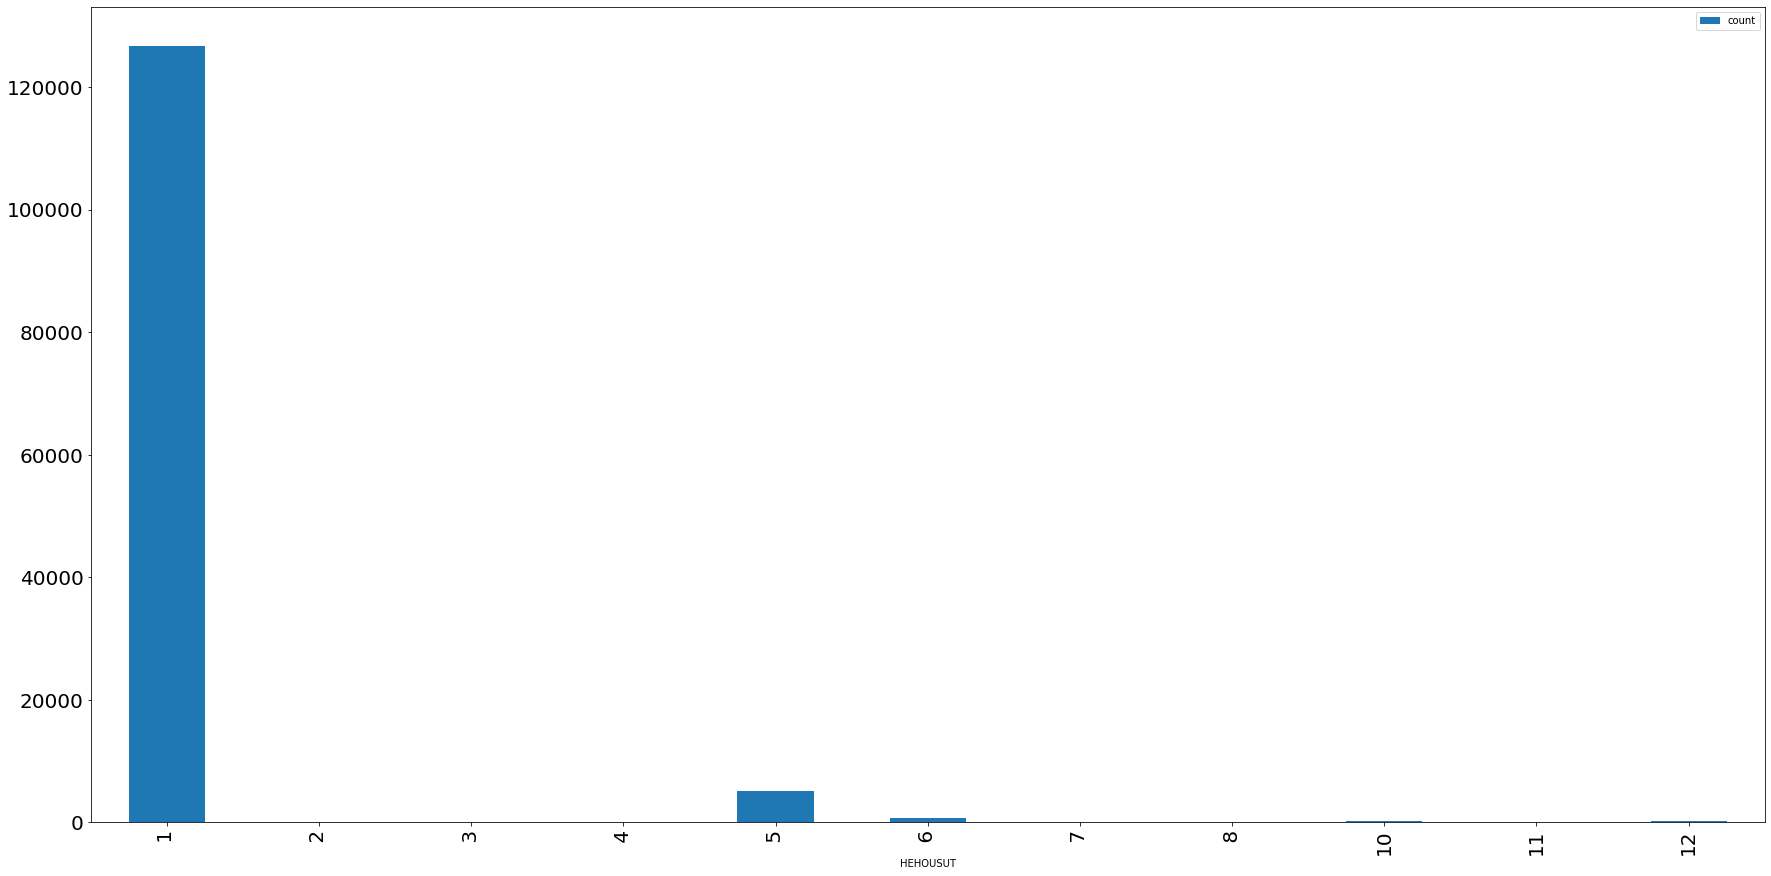

In [9]:
pdf_hsg = df_hsg.toPandas()

pdf_hsg.plot(kind='bar', x='HEHOUSUT',y='count', fontsize=20);

Note that the x-axis is simply numbers, which will require a key to interprete. From the data dictionary, we can find that HEHOUSUT has the following valid entries:

0 - OTHER UNIT \
1 - HOUSE, APARTMENT, FLAT \
2 - HU IN NONTRANSIENT HOTEL, MOTEL, ETC. \
3 - HU PERMANENT IN TRANSIENT HOTEL, MOTEL \
4 - HU IN ROOMING HOUSE \
5 - MOBILE HOME OR TRAILER W/NO PERM. ROOM ADDED \
6 - MOBILE HOME OR TRAILER W/1 OR MORE PERM. ROOMS ADDED \
7 - HU NOT SPECIFIED ABOVE \
8 - QUARTERS NOT HU IN ROOMING OR BRDING HS \
9 - UNIT NOT PERM. IN TRANSIENT HOTL, MOTL \
10 - UNOCCUPIED TENT SITE OR TRLR SITE \
11 - STUDENT QUARTERS IN COLLEGE DORM \
12 - OTHER UNIT NOT SPECIFIED ABOVE

In [10]:
query = '''SELECT 
                HWHHWGT ,
                COUNT(HWHHWGT) as count
            FROM apr21_df 
            GROUP BY 
                HWHHWGT
            ORDER BY 
                HWHHWGT
            '''
spark.sql(query).show()
df_hwgt = spark.sql(query)


+----------+-----+
|   HWHHWGT|count|
+----------+-----+
|   1834097|    2|
|   2163124|    1|
|   2164757|    1|
|   2168646|    1|
|   2193573|    1|
|   2200847|    3|
|   2238030|    1|
|   2271981|    7|
|   2274052|    4|
|   2280601|    1|
|   2287145|    3|
|   2289222|    4|
|   2298096|    4|
|   2312074|    1|
|   2384557|    2|
|   2390022|    1|
|   2396542|    2|
|   2417494|    1|
|   2428587|    2|
|   2441255|    1|
+----------+-----+
only showing top 20 rows



In [11]:
apr21_df.count()

133449

In [14]:
def quick_look(df, col_name):
    '''
    Provides a quick look at a column of date in data frame
    
    parameter:
    ---
    col_name: name of column in df 
    
    output:
    ---
    sql query:
    
    plot:
    '''
    query = f'''SELECT 
                    {col_name} ,
                    COUNT({col_name}) as count
                FROM {df} 
                GROUP BY 
                    {col_name}
                ORDER BY 
                    {col_name}
                '''
    spark.sql(query).show()
    df_check = spark.sql(query)
    pdf_check = df_check.toPandas()

    pdf_check.plot(kind='bar', x=col_name,y='count', fontsize=20);

+--------+-----+
|HEFAMINC|count|
+--------+-----+
|       1| 2011|
|       2| 1114|
|       3| 1268|
|       4| 1978|
|       5| 1898|
|       6| 3701|
|       7| 4668|
|       8| 4536|
|       9| 5371|
|      -1|22446|
|      10| 5777|
|      11| 8453|
|      12| 9025|
|      13|11664|
|      14|15040|
|      15|16773|
|      16|17726|
+--------+-----+



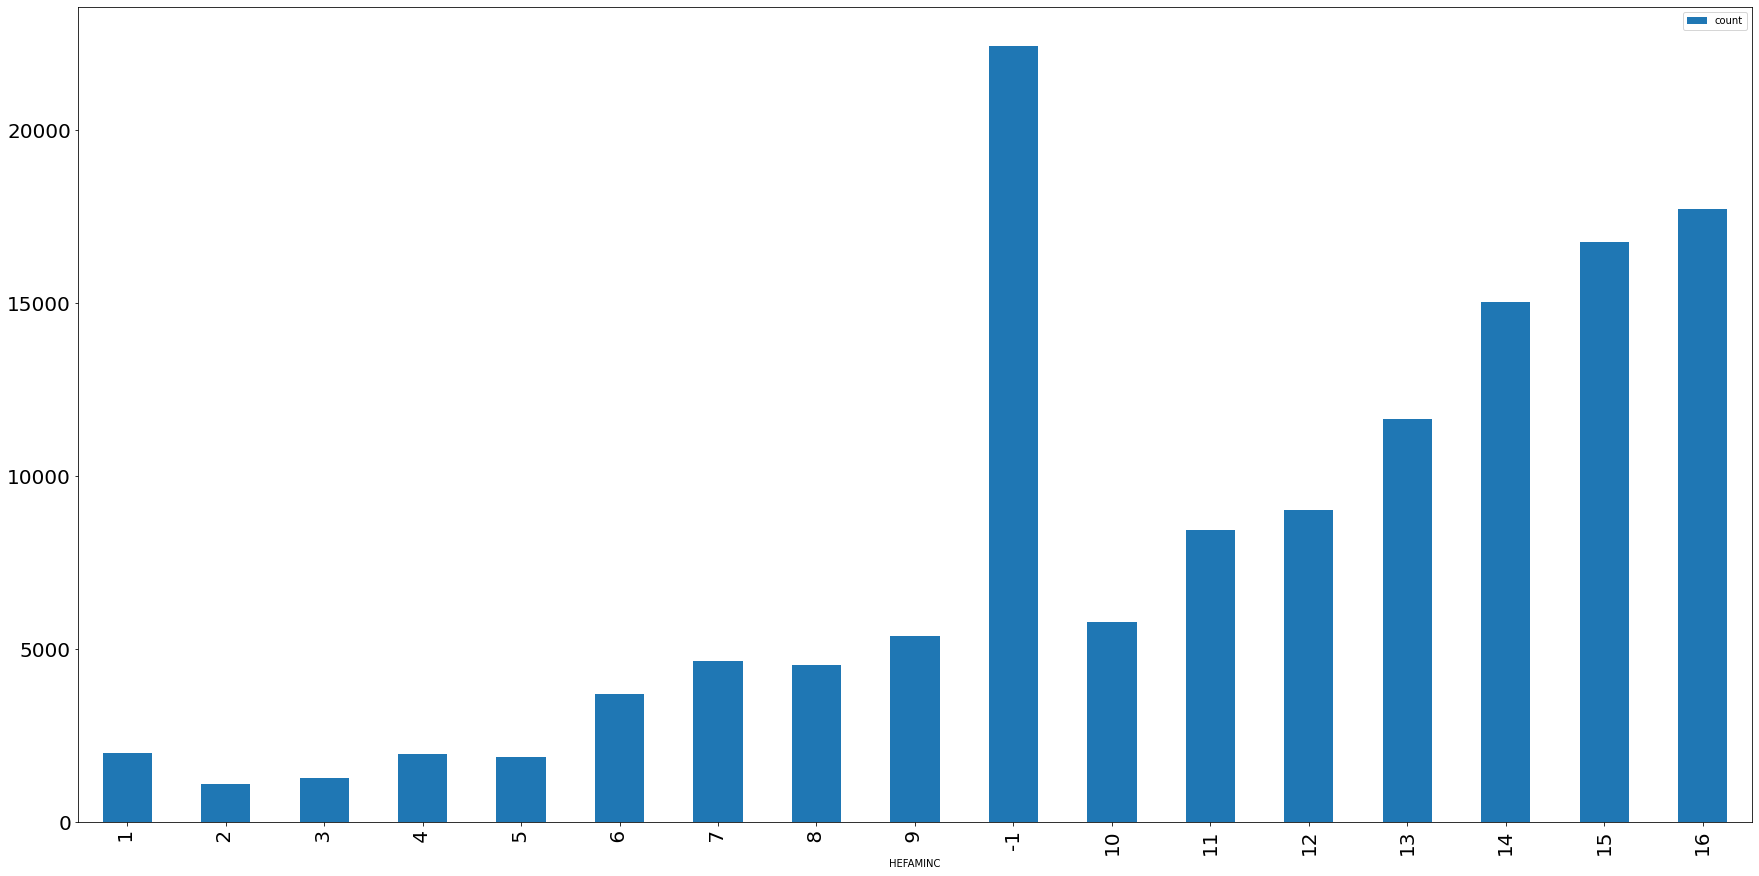

In [24]:
quick_look('apr21_df', 'HEFAMINC')

In [ ]:
query = f'''SELECT 
                    PRTAGE ,
                    
                    COUNT(*) as count
                FROM {df} 
                GROUP BY 
                    {col_name}
                ORDER BY 
                    {col_name}
                '''
spark.sql(query).show()
df_check = spark.sql(query)
pdf_check = df_check.toPandas()

pdf_check.plot(kind='bar', x=col_name,y='count', fontsize=20);

In [57]:
query = '''With t1 as
(
SELECT 
    HRHHID ,
    CASE 
        WHEN PRTAGE >= 0 and PRTAGE <= 20 then '0-20'
        WHEN PRTAGE > 20 and PRTAGE <= 30 then '21-30'
        WHEN PRTAGE > 30 and PRTAGE <= 40 then '31-40'
        WHEN PRTAGE > 40 and PRTAGE <= 50 then '41-50'
        WHEN PRTAGE > 50 and PRTAGE <= 60 then '51-60'
        WHEN PRTAGE > 60 and PRTAGE <= 70 then '61-70'
        WHEN PRTAGE > 70 then 'over_70'
    End as ageBracket,
    PEAFEVER
FROM
    apr21_df
WHERE 
    PEAFEVER > 0
)

SELECT
    t.ageBracket as AgeGroup,
    COUNT(*) as Population,
    SUM(CASE WHEN t.PEAFEVER = 1 THEN 1 ELSE 0 END) AS Vets,
    round(100 * SUM(CASE WHEN t.PEAFEVER = 1 THEN 1 ELSE 0 END) / COUNT(*), 1) as pct
FROM
    apr21_df a
JOIN 
    t1 t ON t.HRHHID=a.HRHHID
GROUP BY
    t.ageBracket
ORDER BY
    t.ageBracket
'''

tmp_df = spark.sql(query)
tmp_df.show()


+--------+----------+----+----+
|AgeGroup|Population|Vets| pct|
+--------+----------+----+----+
|    0-20|     22824|  46| 0.2|
|   21-30|     43768| 758| 1.7|
|   31-40|     53038|1855| 3.5|
|   41-50|     47922|2250| 4.7|
|   51-60|     41440|2843| 6.9|
|   61-70|     35210|3042| 8.6|
| over_70|     29955|6291|21.0|
+--------+----------+----+----+



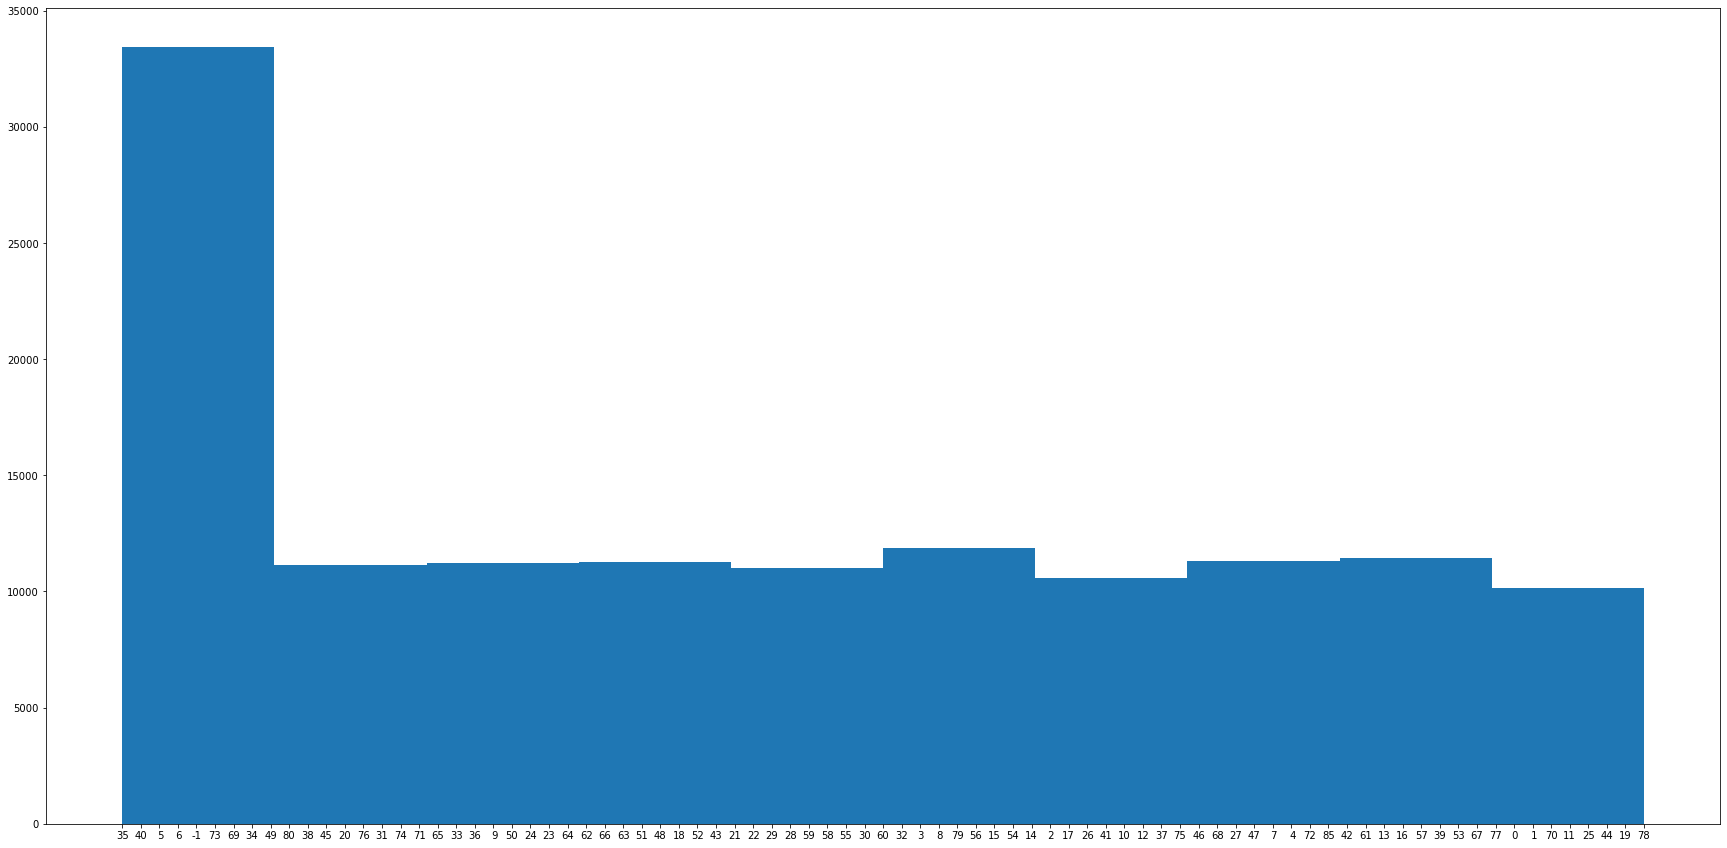

In [66]:
plt.hist(apr21_df.select("PRTAGE").toPandas());

In [173]:
def ageGrouping(age_):
    age = int(age_)
    if age >= 0 and age <= 20:
        return ' U21'
    if age > 20  and age <= 30:
        return '21-30'
    if age > 30  and age <= 40:
        return '31-40'
    if age > 40  and age <= 50:
        return '41-50'
    if age > 50  and age <= 60:
        return '51-60'
    if age > 60  and age <= 70:
        return '61-70'
    if age > 70:
        return 'over_70'
    return '  None'

func_udf = udf(ageGrouping, StringType())

apr21_df_ag = apr21_df.withColumn("AgeGroup", 
    func_udf(apr21_df['PRTAGE'])
  ).withColumn("AgeGroup",when(col("PRPERTYP") == 1, '  child').otherwise(col("AgeGroup")))
apr21_df_ag.select("AgeGroup").show()

+--------+
|AgeGroup|
+--------+
|   31-40|
|   31-40|
|   child|
|   child|
|    None|
| over_70|
|    None|
|    None|
|   61-70|
|   31-40|
|   31-40|
|   41-50|
| over_70|
| over_70|
|   31-40|
| over_70|
|   41-50|
|     U21|
| over_70|
| over_70|
+--------+
only showing top 20 rows



In [174]:
apr21_df_ag.createOrReplaceTempView('apr21_df_ag')

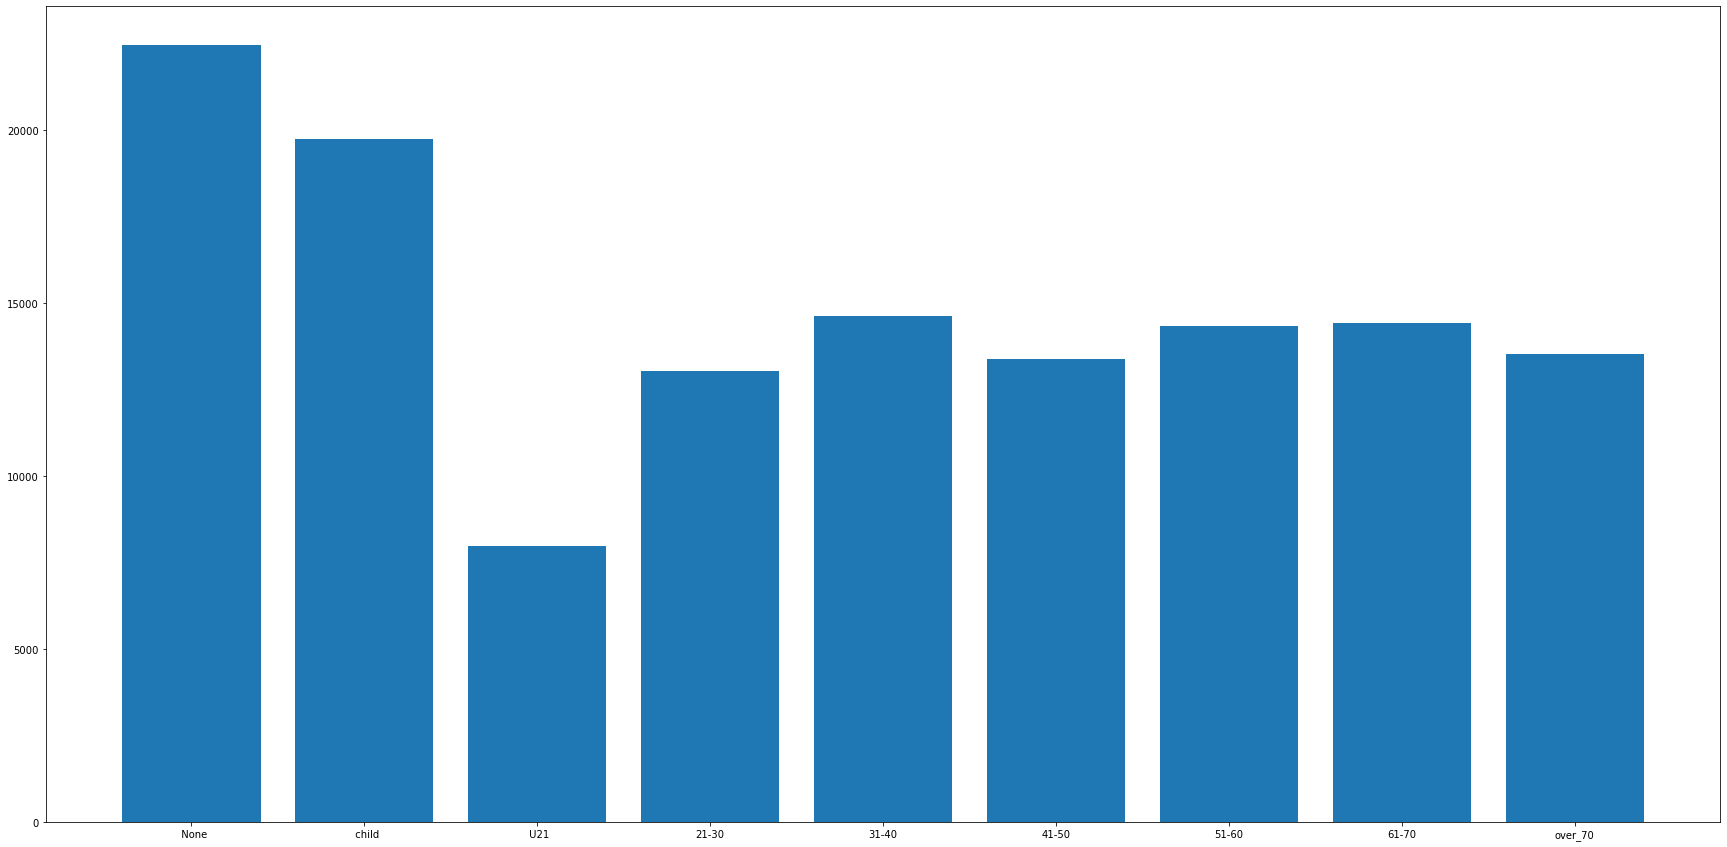

In [175]:
query = '''SELECT
    AgeGroup,
    COUNT(*) as Population
FROM
    apr21_df_ag 
GROUP BY
    AgeGroup
ORDER BY
    AgeGroup
'''

tmp_df = spark.sql(query).toPandas()
tmp_df
plt.bar(tmp_df['AgeGroup'],tmp_df['Population']);

In [176]:
query = '''SELECT
    AgeGroup,
    COUNT(*) as Population,
    SUM(CASE WHEN PEAFEVER = 1 THEN 1 ELSE 0 END) AS Vets,
    round(100 * SUM(CASE WHEN PEAFEVER = 1 THEN 1 ELSE 0 END) / COUNT(*), 1) as pct
FROM
    apr21_df_ag 
GROUP BY
    AgeGroup
ORDER BY
    AgeGroup
'''

tmp_df = spark.sql(query)
tmp_df.show()

+--------+----------+----+----+
|AgeGroup|Population|Vets| pct|
+--------+----------+----+----+
|    None|     22446|   0| 0.0|
|   child|     19733|   0| 0.0|
|     U21|      7971|  11| 0.1|
|   21-30|     13037| 246| 1.9|
|   31-40|     14619| 513| 3.5|
|   41-50|     13367| 660| 4.9|
|   51-60|     14333|1044| 7.3|
|   61-70|     14423|1287| 8.9|
| over_70|     13520|2864|21.2|
+--------+----------+----+----+



In [177]:
query = '''SELECT
    AgeGroup,
    COUNT(*) as Pop,
    SUM(CASE WHEN (PEMLR = 1) THEN 1 ELSE 0 END) AS working,
    round(100 * SUM(CASE WHEN PEMLR = 1 THEN 1 ELSE 0 END) / COUNT(*), 1) as w_pct,
    SUM(CASE WHEN (PEMLR = 5) THEN 1 ELSE 0 END) AS retired,
    round(100 * SUM(CASE WHEN PEMLR = 5 THEN 1 ELSE 0 END) / COUNT(*), 1) as ret_pct,
    SUM(CASE WHEN (PEMLR = 6) THEN 1 ELSE 0 END) AS disabled,
    round(100 * SUM(CASE WHEN PEMLR = 6 THEN 1 ELSE 0 END) / COUNT(*), 1) as dis_pct,
    SUM(CASE WHEN (PEMLR = 3 or PEMLR = 4) THEN 1 ELSE 0 END) AS unemployed,
    round(100 * SUM(CASE WHEN (PEMLR = 3 or PEMLR = 4) THEN 1 ELSE 0 END) / COUNT(*), 1) as unem_pct
FROM
    apr21_df_ag 
GROUP BY
    AgeGroup
ORDER BY
    AgeGroup
'''

tmp_df = spark.sql(query)
tmp_df.show()

+--------+-----+-------+-----+-------+-------+--------+-------+----------+--------+
|AgeGroup|  Pop|working|w_pct|retired|ret_pct|disabled|dis_pct|unemployed|unem_pct|
+--------+-----+-------+-----+-------+-------+--------+-------+----------+--------+
|    None|22446|      0|  0.0|      0|    0.0|       0|    0.0|         0|     0.0|
|   child|19733|      0|  0.0|      0|    0.0|       0|    0.0|         0|     0.0|
|     U21| 7971|   2351| 29.5|     13|    0.2|     124|    1.6|       278|     3.5|
|   21-30|13037|   9095| 69.8|     67|    0.5|     346|    2.7|       711|     5.5|
|   31-40|14619|  10998| 75.2|    143|    1.0|     438|    3.0|       568|     3.9|
|   41-50|13367|   9943| 74.4|    184|    1.4|     763|    5.7|       484|     3.6|
|   51-60|14333|   9843| 68.7|   1116|    7.8|    1420|    9.9|       488|     3.4|
|   61-70|14423|   5614| 38.9|   6566|   45.5|    1130|    7.8|       269|     1.9|
| over_70|13520|   1456| 10.8|  11329|   83.8|     388|    2.9|        64|  

**PEEDUCA** \
31	LESS THAN 1ST GRADE \
32	1ST, 2ND, 3RD OR 4TH GRADE \
33	5TH OR 6TH GRADE \
34	7TH OR 8TH GRADE \
35	9TH GRADE \
36	10TH GRADE \
37	11TH GRADE \
38	12TH GRADE NO DIPLOMA \
39	HIGH SCHOOL GRAD-DIPLOMA OR EQUIV (GED) \
40	SOME COLLEGE BUT NO DEGREE \
41	ASSOCIATE DEGREE-OCCUPATIONAL/VOCATIONAL \
42	ASSOCIATE DEGREE-ACADEMIC PROGRAM \
43	BACHELOR'S DEGREE (EX: BA, AB, BS) \
44	MASTER'S DEGREE (EX: MA, MS, MEng, MEd, MSW) \
45	PROFESSIONAL SCHOOL DEG (EX: MD, DDS, DVM) \
46	DOCTORATE DEGREE (EX: PhD, EdD) \

In [190]:
query = '''SELECT
    AgeGroup,
    COUNT(*) as Pop,
    SUM(CASE WHEN (PEEDUCA < 39) THEN 1 ELSE 0 END) AS lt_HS,
    round(100 * SUM(CASE WHEN (PEEDUCA < 39) THEN 1 ELSE 0 END) / COUNT(*), 1) as lt_HS_pct,
    SUM(CASE WHEN (PEEDUCA = 39 or PEEDUCA = 40) THEN 1 ELSE 0 END) AS HS_Grad,
    round(100 * SUM(CASE WHEN (PEEDUCA = 39 or PEEDUCA = 40) THEN 1 ELSE 0 END) / COUNT(*), 1) as HS_pct,
    SUM(CASE WHEN (PEEDUCA = 41 or PEEDUCA = 42) THEN 1 ELSE 0 END) AS AA,
    round(100 * SUM(CASE WHEN (PEEDUCA = 41 or PEEDUCA = 42) THEN 1 ELSE 0 END) / COUNT(*), 1) as AA_pct,
    SUM(CASE WHEN (PEEDUCA = 43) THEN 1 ELSE 0 END) AS Bachelors,
    round(100 * SUM(CASE WHEN (PEEDUCA = 43) THEN 1 ELSE 0 END) / COUNT(*), 1) as Bach_pct,
    SUM(CASE WHEN (PEEDUCA = 44) THEN 1 ELSE 0 END) AS Masters,
    round(100 * SUM(CASE WHEN (PEEDUCA = 44) THEN 1 ELSE 0 END) / COUNT(*), 1) as M_pct,
    SUM(CASE WHEN (PEEDUCA = 45) THEN 1 ELSE 0 END) AS Professional,
    round(100 * SUM(CASE WHEN (PEEDUCA = 45) THEN 1 ELSE 0 END) / COUNT(*), 1) as Prof_pct,
    SUM(CASE WHEN (PEEDUCA = 46) THEN 1 ELSE 0 END) AS Doctorate,
    round(100 * SUM(CASE WHEN (PEEDUCA = 46) THEN 1 ELSE 0 END) / COUNT(*), 1) as Doc_pct
FROM
    apr21_df_ag 
GROUP BY
    AgeGroup
ORDER BY
    AgeGroup
'''

ed_df = spark.sql(query).toPandas()
ed_pdf = ed_df[ed_df['AgeGroup'] != '  None']
ed_pdf

,AgeGroup,Pop,lt_HS,lt_HS_pct,HS_Grad,HS_pct,AA,AA_pct,Bachelors,Bach_pct,Masters,M_pct,Professional,Prof_pct,Doctorate,Doc_pct
1,child,19733,19733,100.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,U21,7971,5161,64.7,2644,33.2,104,1.3,53,0.7,6,0.1,0,0.0,3,0.0
3,21-30,13037,760,5.8,6848,52.5,1284,9.8,3264,25.0,710,5.4,87,0.7,84,0.6
4,31-40,14619,1052,7.2,5753,39.4,1561,10.7,3877,26.5,1743,11.9,273,1.9,360,2.5
5,41-50,13367,1178,8.8,5264,39.4,1486,11.1,3272,24.5,1633,12.2,220,1.6,314,2.3
6,51-60,14333,1234,8.6,6403,44.7,1672,11.7,3092,21.6,1429,10.0,205,1.4,298,2.1
7,61-70,14423,1182,8.2,6706,46.5,1632,11.3,2903,20.1,1453,10.1,229,1.6,318,2.2
8,over_70,13520,1543,11.4,6591,48.8,1140,8.4,2410,17.8,1282,9.5,248,1.8,306,2.3


HEHOUSUT - 2 - TYPE OF HOUSING UNIT -   31 - 32 \
 \
0	OTHER UNIT \
1	HOUSE, APARTMENT, FLAT \
2	HU IN NONTRANSIENT HOTEL, MOTEL, ETC. \
3	HU PERMANENT IN TRANSIENT HOTEL, MOTEL \
4	HU IN ROOMING HOUSE \
5	MOBILE HOME OR TRAILER W/NO PERM. ROOM ADDED \
6	MOBILE HOME OR TRAILER W/1 OR MORE PERM. ROOMS ADDED \
7	HU NOT SPECIFIED ABOVE \
8	QUARTERS NOT HU IN ROOMING OR BRDING HS \
9	UNIT NOT PERM. IN TRANSIENT HOTL, MOTL \
10	UNOCCUPIED TENT SITE OR TRLR SITE \
11	STUDENT QUARTERS IN COLLEGE DORM \
12	OTHER UNIT NOT SPECIFIED ABOVE

In [185]:
query = '''SELECT
    AgeGroup,
    COUNT(*) as Pop,
    SUM(CASE WHEN (HEHOUSUT = 1) THEN 1 ELSE 0 END) AS hs_apt_flat,
    round(100 * SUM(CASE WHEN (HEHOUSUT = 1) THEN 1 ELSE 0 END) / COUNT(*), 1) as hs_apt_flat_pct,
    SUM(CASE WHEN (HEHOUSUT = 5 or HEHOUSUT = 6) THEN 1 ELSE 0 END) AS mobile_home,
    round(100 * SUM(CASE WHEN (HEHOUSUT = 5 or HEHOUSUT = 6) THEN 1 ELSE 0 END) / COUNT(*), 1) as mob_pct,
    SUM(CASE WHEN (HEHOUSUT = 0 or HEHOUSUT = 2 or HEHOUSUT = 3 or HEHOUSUT = 4 or HEHOUSUT > 6) THEN 1 ELSE 0 END) AS other,
    round(100 * SUM(CASE WHEN (HEHOUSUT = 0 or HEHOUSUT = 2 or HEHOUSUT = 3 or HEHOUSUT = 4 or HEHOUSUT > 6) THEN 1 ELSE 0 END) / COUNT(*), 1) as other_pct
FROM
    apr21_df_ag 
GROUP BY
    AgeGroup
ORDER BY
    AgeGroup
'''

hsg_pdf = spark.sql(query).toPandas()
hsg_pdf

,AgeGroup,Pop,hs_apt_flat,hs_apt_flat_pct,mobile_home,mob_pct,other,other_pct
0,None,22446,20636,91.9,1131,5.0,679,3.0
1,child,19733,18762,95.1,955,4.8,16,0.1
2,U21,7971,7602,95.4,365,4.6,4,0.1
3,21-30,13037,12485,95.8,539,4.1,13,0.1
4,31-40,14619,14017,95.9,572,3.9,30,0.2
5,41-50,13367,12809,95.8,538,4.0,20,0.1
6,51-60,14333,13649,95.2,658,4.6,26,0.2
7,61-70,14423,13811,95.8,581,4.0,31,0.2
8,over_70,13520,12986,96.1,490,3.6,44,0.3


In [181]:
query = '''SELECT
    HUBUSL1,
    COUNT(*)
FROM
    apr21_df_ag 
WHERE 
    HUBUSL1 > 0
GROUP BY
    HUBUSL1
ORDER BY 
    HUBUSL1
'''

tmp_df = spark.sql(query).toPandas()
tmp_df


,HUBUSL1,count(1)
0,1,8846
1,2,3956
2,3,279
3,4,146
4,5,50
5,6,14
6,8,16


In [186]:
query = '''SELECT
    HUBUS ,
    COUNT(*) as Pop,
    SUM(CASE WHEN (PEAFEVER = 1) THEN 1 ELSE 0 END) AS VETS,
    round(100 * SUM(CASE WHEN (PEAFEVER = 1) THEN 1 ELSE 0 END) / COUNT(*), 1) as VETS_pct,
    SUM(CASE WHEN (PEAFEVER = 2) THEN 1 ELSE 0 END) AS CIV,
    round(100 * SUM(CASE WHEN (PEAFEVER = 2) THEN 1 ELSE 0 END) / COUNT(*), 1) as CIV_pct
FROM
    apr21_df_ag 
WHERE 
    HUBUS >= 0
GROUP BY
    HUBUS
ORDER BY 
    HUBUS
'''

tmp_pdf = spark.sql(query).toPandas()
tmp_pdf


,HUBUS,Pop,VETS,VETS_pct,CIV,CIV_pct
0,1,14423,631,4.4,10444,72.4
1,2,96228,5973,6.2,70717,73.5


In [187]:
query = '''SELECT
    PEAFEVER ,
    COUNT(*) as Pop,
    SUM(CASE WHEN (HUBUS = 1) THEN 1 ELSE 0 END) AS OWNER,
    round(100 * SUM(CASE WHEN (HUBUS = 1) THEN 1 ELSE 0 END) / COUNT(*), 1) as OWNER_pct,
    SUM(CASE WHEN (HUBUS = 2) THEN 1 ELSE 0 END) AS OTHER,
    round(100 * SUM(CASE WHEN (HUBUS = 2) THEN 1 ELSE 0 END) / COUNT(*), 1) as OTHER_pct
FROM
    apr21_df_ag 
WHERE 
    PEAFEVER >= 0
GROUP BY
    PEAFEVER
ORDER BY 
    PEAFEVER
'''

tmp_pdf = spark.sql(query).toPandas()
tmp_pdf


,PEAFEVER,Pop,OWNER,OWNER_pct,OTHER,OTHER_pct
0,1,6625,631,9.5,5973,90.2
1,2,81459,10444,12.8,70717,86.8


In [188]:
query = '''SELECT
    PRPERTYP,
    COUNT(*)
FROM
    apr21_df_ag 
GROUP BY
    PRPERTYP
ORDER BY 
    PRPERTYP
'''

tmp_pdf = spark.sql(query).toPandas()
tmp_pdf


,PRPERTYP,count(1)
0,1,19733
1,2,90860
2,3,410
3,-1,22446


In [195]:
ed_pdf

,AgeGroup,Pop,lt_HS,lt_HS_pct,HS_Grad,HS_pct,AA,AA_pct,Bachelors,Bach_pct,Masters,M_pct,Professional,Prof_pct,Doctorate,Doc_pct
1,child,19733,19733,100.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,U21,7971,5161,64.7,2644,33.2,104,1.3,53,0.7,6,0.1,0,0.0,3,0.0
3,21-30,13037,760,5.8,6848,52.5,1284,9.8,3264,25.0,710,5.4,87,0.7,84,0.6
4,31-40,14619,1052,7.2,5753,39.4,1561,10.7,3877,26.5,1743,11.9,273,1.9,360,2.5
5,41-50,13367,1178,8.8,5264,39.4,1486,11.1,3272,24.5,1633,12.2,220,1.6,314,2.3
6,51-60,14333,1234,8.6,6403,44.7,1672,11.7,3092,21.6,1429,10.0,205,1.4,298,2.1
7,61-70,14423,1182,8.2,6706,46.5,1632,11.3,2903,20.1,1453,10.1,229,1.6,318,2.2
8,over_70,13520,1543,11.4,6591,48.8,1140,8.4,2410,17.8,1282,9.5,248,1.8,306,2.3


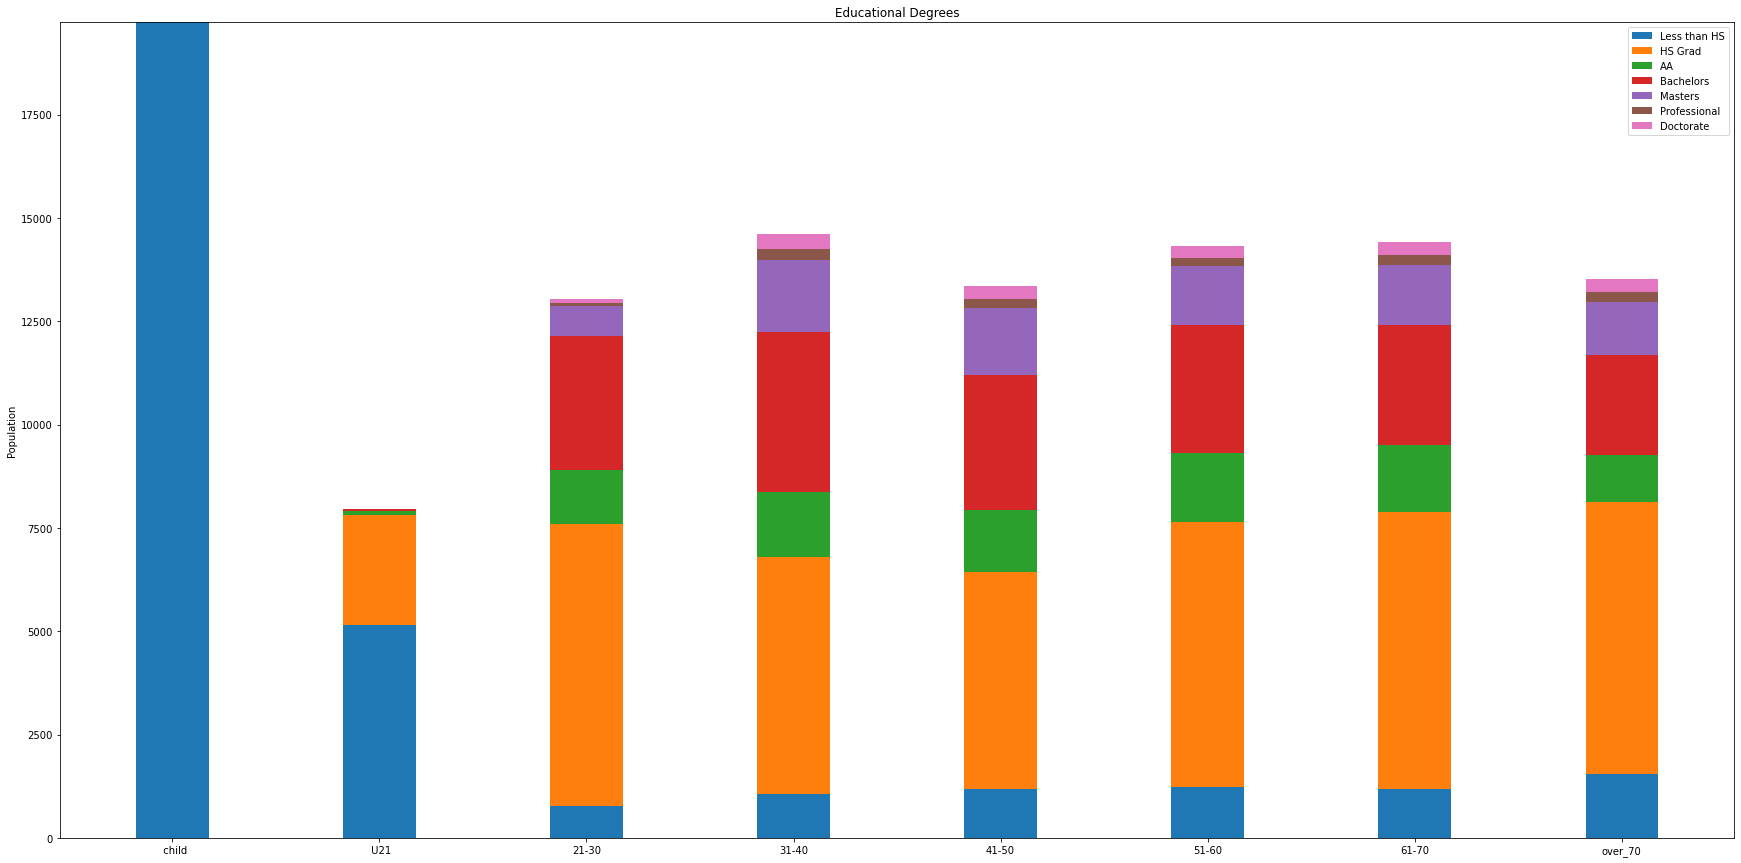

In [202]:
labels = ed_pdf.AgeGroup
Pop = ed_pdf.Pop
lt_hs = ed_pdf.lt_HS
hs_grad = ed_pdf.HS_Grad
aa  = ed_pdf.AA
bach = ed_pdf.Bachelors
mas = ed_pdf.Masters
prof = ed_pdf.Professional
doc = ed_pdf.Doctorate
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, lt_hs, width, label='Less than HS')
ax.bar(labels, hs_grad, width, bottom=lt_hs, label='HS Grad')
ax.bar(labels, aa, width, bottom=lt_hs+hs_grad, label='AA')
ax.bar(labels, bach, width, bottom=lt_hs+hs_grad+aa, label='Bachelors')
ax.bar(labels, mas, width, bottom=lt_hs+hs_grad+aa+bach, label='Masters')
ax.bar(labels, prof, width, bottom=lt_hs+hs_grad+aa+bach+mas, label='Professional')
ax.bar(labels, doc, width, bottom=lt_hs+hs_grad+aa+bach+mas+prof, label='Doctorate')

ax.set_ylabel('Population')
ax.set_title('Educational Degrees')
ax.legend()

plt.show()

In [199]:
ed_pdf.keys()

Index(['AgeGroup', 'Pop', 'lt_HS', 'lt_HS_pct', 'HS_Grad', 'HS_pct', 'AA',
       'AA_pct', 'Bachelors', 'Bach_pct', 'Masters', 'M_pct', 'Professional',
       'Prof_pct', 'Doctorate', 'Doc_pct'],
      dtype='object')

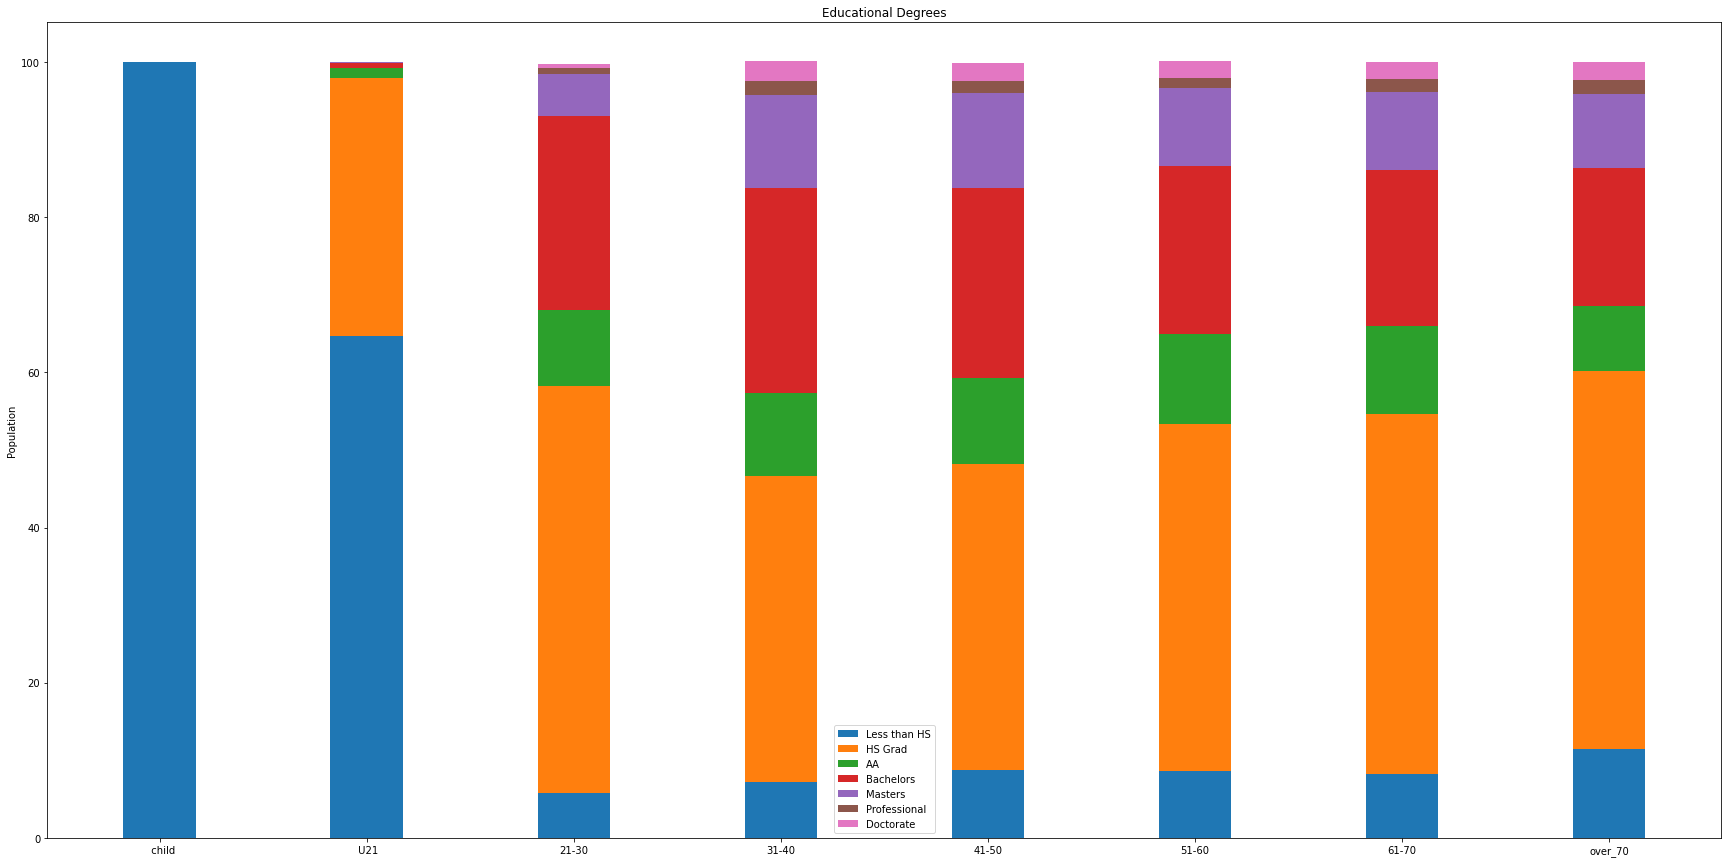

In [203]:
labels = ed_pdf.AgeGroup
Pop = ed_pdf.Pop
lt_hs = ed_pdf.lt_HS_pct
hs_grad = ed_pdf.HS_pct
aa  = ed_pdf.AA_pct
bach = ed_pdf.Bach_pct
mas = ed_pdf.M_pct
prof = ed_pdf.Prof_pct
doc = ed_pdf.Doc_pct
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, lt_hs, width, label='Less than HS')
ax.bar(labels, hs_grad, width, bottom=lt_hs, label='HS Grad')
ax.bar(labels, aa, width, bottom=lt_hs+hs_grad, label='AA')
ax.bar(labels, bach, width, bottom=lt_hs+hs_grad+aa, label='Bachelors')
ax.bar(labels, mas, width, bottom=lt_hs+hs_grad+aa+bach, label='Masters')
ax.bar(labels, prof, width, bottom=lt_hs+hs_grad+aa+bach+mas, label='Professional')
ax.bar(labels, doc, width, bottom=lt_hs+hs_grad+aa+bach+mas+prof, label='Doctorate')

ax.set_ylabel('Population')
ax.set_title('Educational Degrees')
ax.legend()

plt.show()

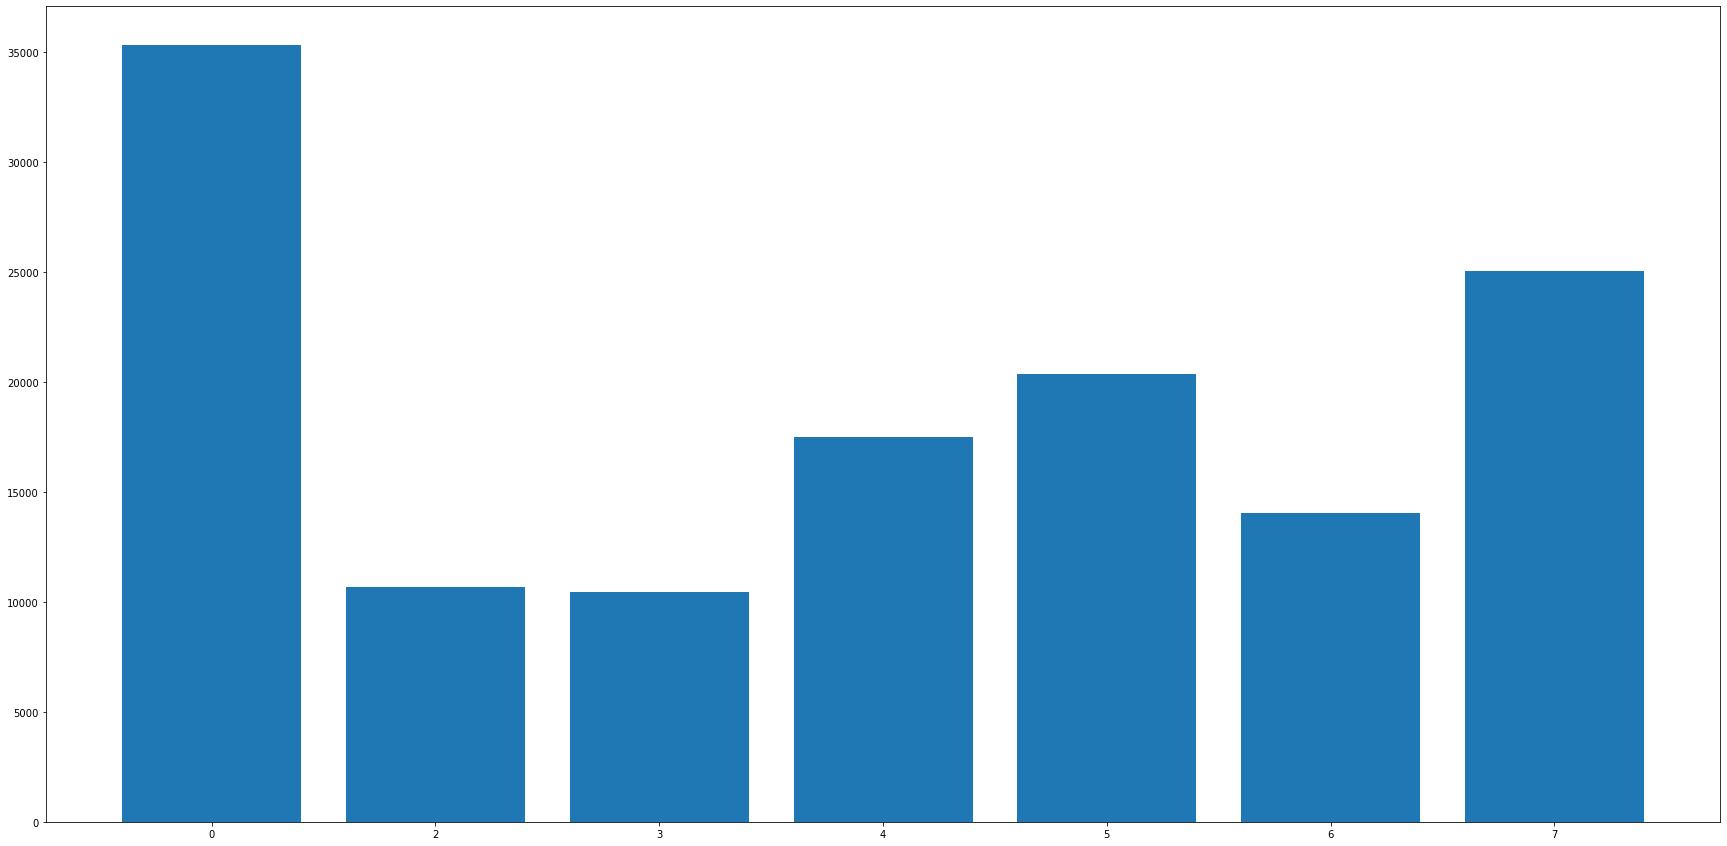

In [212]:
query = '''SELECT 
                GTCBSASZ ,
                COUNT(GTCBSASZ) as count
            FROM apr21_df_ag
            GROUP BY 
                GTCBSASZ
            ORDER BY 
                GTCBSASZ
            '''
tmp_df = spark.sql(query).toPandas()
plt.bar(tmp_df['GTCBSASZ'],tmp_df['count']);

In [ ]:
apr21_df_ag.describe()